# Compton Effekt

## initial imports

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks,find_peaks_cwt
import scipy.signal as sig
import scipy.special as sp
import scienceplots
plt.figure()
plt.style.use('science')
plt.rcParams['errorbar.capsize'] = 5
# plt.rcParams['text.usetex'] = False # disable latex
plt.rcParams['figure.dpi'] = 150
import os
if not os.path.exists('Compton/output'):
    os.makedirs('Compton/output')

<Figure size 640x480 with 0 Axes>

In [2]:
#aliases
from uncertainties import ufloat as uf
from uncertainties.unumpy import uarray as ua
from uncertainties.unumpy import nominal_values as nv
from uncertainties.unumpy import std_devs as sd

In [3]:
# normalize
def normalize(arr, t_min, t_max):    
    try:
        arr = arr.to_numpy()
    except:
        pass
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
def simple_norm(arr):
    try:
        arr = arr.to_numpy()
    except:
        pass
    norm_arr = []
    diff = 1
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr)
        norm_arr.append(temp)
    return norm_arr
def norm2(arr):
    try:
        arr = arr.to_numpy()
    except:
        pass
    diff_arr = max(arr) - min(arr)   
    return arr/diff_arr

def mapcolors(n):
    """Return a list of n colors from the default colormap"""
    return [plt.cm.jet(int(x*plt.cm.jet.N/n)) for x in range(n)]

## 1 Kalibrierung

### import data

In [4]:
co60_kalib = pd.read_csv('Compton/data/1-Kalibrierung/Co60_kalibr.txt', sep='\t', header=None, names=['channel', 'counts'])
cs137_kalib = pd.read_csv('Compton/data/1-Kalibrierung/Cs137_kalibr.txt', sep='\t', header=None, names=['channel', 'counts'])
na22_kalib = pd.read_csv('Compton/data/1-Kalibrierung/Na22_kalibr.txt', sep='\t', header=None, names=['channel', 'counts'])
kalib_energies = unp.uarray([1173.2,1332.5,661.6,511,1275],12)

co60_kalib

,channel,counts
0,0,164
1,1,1012
2,2,908
3,3,924
4,4,941
...,...,...
251,251,14
252,252,14
253,253,17
254,254,6


### analyze data

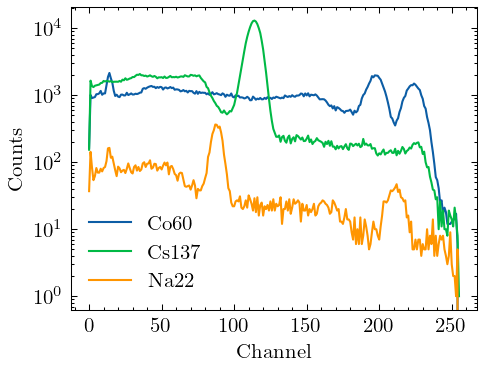

In [5]:
plt.figure()
plt.plot(co60_kalib['channel'], co60_kalib['counts'], label='Co60')
plt.plot(cs137_kalib['channel'], cs137_kalib['counts'], label='Cs137')
plt.plot(na22_kalib['channel'], na22_kalib['counts'], label='Na22')
plt.legend()

plt.xlabel('Channel')
plt.ylabel('Counts')

plt.yscale('log')

Text(0, 0.5, 'Normierte Intensität')

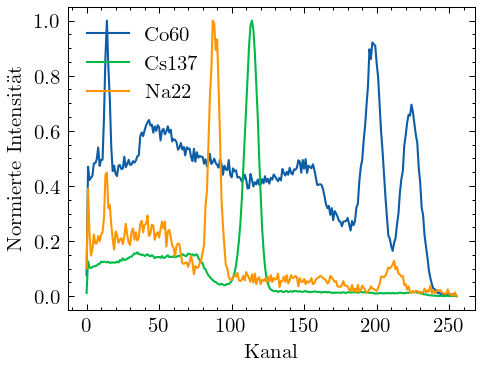

In [6]:
plt.figure()
plt.plot(co60_kalib['channel'], simple_norm(co60_kalib['counts']), label='Co60')
plt.plot(cs137_kalib['channel'], simple_norm(cs137_kalib['counts']), label='Cs137')
plt.plot(na22_kalib['channel'], simple_norm(na22_kalib['counts']), label='Na22')
plt.legend()

plt.xlabel('Kanal')
plt.ylabel('Normierte Intensität')

In [7]:
def gauss(x, x0, a, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def un_gauss(x, x0, a, sigma):
    return a*unp.exp(-(x-x0)**2/(2*sigma**2))

def gauss_area(a, sigma):
    return a*np.sqrt(2*np.pi)*sigma

f_{c60,1} = 197.06 \pm 0.14 \cdot \exp(-\frac{(197.06 \pm 0.14-x)^2}{2\cdot (6.91 \pm 0.16)^2})
f_{c60,2} = \num{223.36 \pm 0.06} \cdot \exp(-\frac{(\num{223.36 \pm 0.06}-x)^2}{2\cdot (\num{6.55 \pm 0.07})^2})


[197.0591372187202+/-0.13601005848583425,
 223.3634044946282+/-0.06197124592303979]

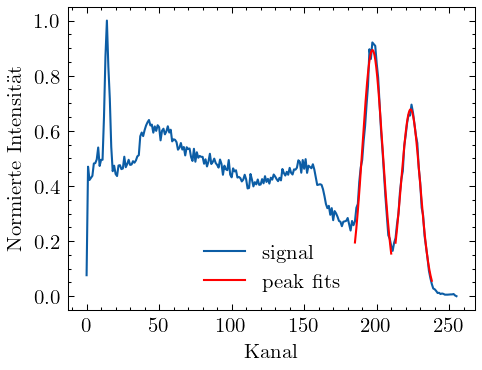

In [8]:
x,y= co60_kalib['channel'], simple_norm(co60_kalib['counts'])
plt.figure()
plt.plot(x,y,label='signal')


# plt.xlim(170)
xl = np.linspace(185,210,500)
# plt.plot(x[185:210],y[185:210])
c,cov = curve_fit(gauss, x[185:210], y[185:210], p0=[200,0.5,5])
print(rf"f_{{c60,1}} = {un.ufloat(c[0],np.sqrt(cov[0][0])):L} \cdot \exp(-\frac{{({un.ufloat(c[0],np.sqrt(cov[0][0])):L}-x)^2}}{{2\cdot ({un.ufloat(c[2],np.sqrt(cov[2][2])):L})^2}})")
plt.plot(xl, gauss(xl, *c), label='peak fits',c='r')

c60_peak1 = un.ufloat(c[0],np.sqrt(cov[0][0]))

# plt.plot(x[213:238],y[213:238])

xl = np.linspace(213,238,500)
c,cov = curve_fit(gauss, x[213:238], y[213:238], p0=[230,0.5,5])
print(rf"f_{{c60,2}} = \num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}} \cdot \exp(-\frac{{(\num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}}-x)^2}}{{2\cdot (\num{{{un.ufloat(c[2],np.sqrt(cov[2][2])):L}}})^2}})")

plt.plot(xl, gauss(xl, *c),c='r')

c60_peak2 = un.ufloat(c[0],np.sqrt(cov[0][0]))

c60_peaks = [c60_peak1,c60_peak2]

# plt.title('Co60')
plt.xlabel('Kanal')
plt.ylabel('Normierte Intensität')
plt.legend()
plt.savefig('Compton/output/1-Co60_peaks.pdf')
c60_peaks

f_{cs137} = \num{113.67 \pm 0.06} \cdot \exp(-\frac{(\num{113.67 \pm 0.06}-x)^2}{2\cdot (\num{4.62 \pm 0.06})^2})


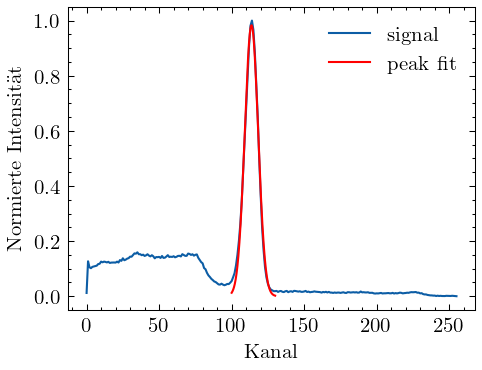

In [9]:
x,y= cs137_kalib['channel'], simple_norm(cs137_kalib['counts'])
plt.figure()
plt.plot(x,y,label='signal')

xl = np.linspace(100,130,500)
c,cov = curve_fit(gauss, x[100:130], y[100:130], p0=[110,0.5,5])
print(rf"f_{{cs137}} = \num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}} \cdot \exp(-\frac{{(\num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}}-x)^2}}{{2\cdot (\num{{{un.ufloat(c[2],np.sqrt(cov[2][2])):L}}})^2}})")
plt.plot(xl, gauss(xl, *c), label='peak fit',c='r')
cs137_peaks = [un.ufloat(c[0],np.sqrt(cov[0][0]))]

# plt.title('Cs137')
plt.xlabel('Kanal')
plt.ylabel('Normierte Intensität')

plt.legend()

plt.savefig('Compton/output/1-Cs137_peaks.pdf')


f_{na22,1} = \num{87.98 \pm 0.13} \cdot \exp(-\frac{(\num{87.98 \pm 0.13}-x)^2}{2\cdot (\num{3.90 \pm 0.13})^2})
f_{na22,2} = \num{210.89 \pm 0.23} \cdot \exp(-\frac{(\num{210.89 \pm 0.23}-x)^2}{2\cdot (\num{6.38 \pm 0.27})^2})


[87.97586986466482+/-0.13150764209203783,
 210.88750572513192+/-0.2310671600610215]

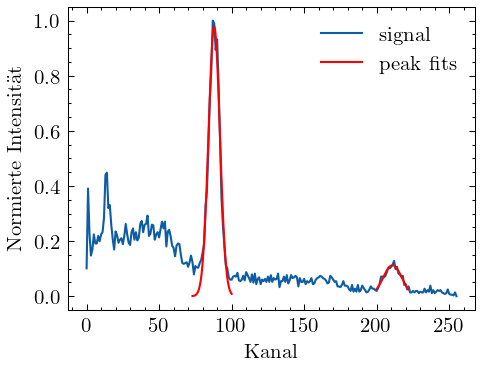

In [10]:
x,y= na22_kalib['channel'],simple_norm(na22_kalib['counts'])
plt.figure()
plt.plot(x,y,label='signal')

# na22_peaks, _= sig.find_peaks(y, height=200, distance=20)
# plt.scatter(x[na22_peaks],y[na22_peaks], label='peaks')
# plt.xlim(50,150)

xl = np.linspace(73,100,100)
c,cov = curve_fit(gauss, x[73:100], y[73:100], p0=[90,0.5,5])
print(rf"f_{{na22,1}} = \num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}} \cdot \exp(-\frac{{(\num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}}-x)^2}}{{2\cdot (\num{{{un.ufloat(c[2],np.sqrt(cov[2][2])):L}}})^2}})")
plt.plot(xl, gauss(xl, *c), label='peak fits',c='r')

na22_peak1 = un.ufloat(c[0],np.sqrt(cov[0][0]))

xl = np.linspace(200,222,100)
c,cov = curve_fit(gauss, x[200:222], y[200:222], p0=[210,0.5,5])
print(rf"f_{{na22,2}} = \num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}} \cdot \exp(-\frac{{(\num{{{un.ufloat(c[0],np.sqrt(cov[0][0])):L}}}-x)^2}}{{2\cdot (\num{{{un.ufloat(c[2],np.sqrt(cov[2][2])):L}}})^2}})")
plt.plot(xl, gauss(xl, *c),c='r')
na22_peak2 = un.ufloat(c[0],np.sqrt(cov[0][0]))

na22_peaks = [na22_peak1,na22_peak2]

# plt.title('Na22')
plt.xlabel('Kanal')
plt.ylabel('Normierte Intensität')
plt.legend()

plt.savefig('Compton/output/1-Na22_peaks.pdf')
na22_peaks


In [11]:
def linfit(x,a,b):
    return a*x+b

In [12]:
kalib_channels = np.array([])
kalib_channels = np.append(kalib_channels,c60_peaks)
kalib_channels = np.append(kalib_channels,cs137_peaks)
kalib_channels = np.append(kalib_channels,na22_peaks)

In [13]:
print(r"\begin{tabular}{c|c}")
print(r"Energie & Kanalnr. \\ \hline")
for e,c in zip(kalib_channels, kalib_channels):
    print(rf"\SI{{{e:L}}}{{\kilo\electronvolt}} & \num{{{c:L}}} \\\hline")
print(r"\end{tabular}")

\begin{tabular}{c|c}
Energie & Kanalnr. \\ \hline
\SI{197.06 \pm 0.14}{\kilo\electronvolt} & \num{197.06 \pm 0.14} \\\hline
\SI{223.36 \pm 0.06}{\kilo\electronvolt} & \num{223.36 \pm 0.06} \\\hline
\SI{113.67 \pm 0.06}{\kilo\electronvolt} & \num{113.67 \pm 0.06} \\\hline
\SI{87.98 \pm 0.13}{\kilo\electronvolt} & \num{87.98 \pm 0.13} \\\hline
\SI{210.89 \pm 0.23}{\kilo\electronvolt} & \num{210.89 \pm 0.23} \\\hline
\end{tabular}


a = 6.14(7)keV/chn 	 b = -32+/-13keV
f(x) = \SI{6.14 \pm 0.07}{\kilo\elektronvolt} \cdot x + \SI{-32 \pm 13}{\kilo\elektronvolt}


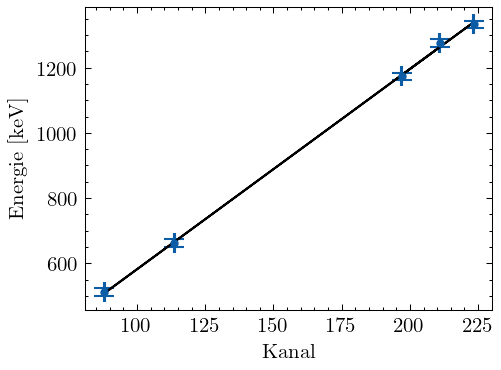

In [14]:
x ,y = unp.nominal_values(kalib_channels),unp.nominal_values(kalib_energies)
xerr,yerr = unp.std_devs(kalib_channels),unp.std_devs(kalib_energies)
plt.figure()
plt.errorbar(x,y,yerr,xerr,fmt='.',label='data')

c,cov = curve_fit(linfit,x,y,sigma=yerr)
perr=np.sqrt(np.diag(cov))
plt.plot(x,linfit(x,*c),label='fit',c='k')

eich_a = unp.uarray(c[0],perr[0])
eich_b = unp.uarray(c[1],perr[1])
print(f'a = {eich_a:S}keV/chn \t b = {eich_b}keV')
print(rf"f(x) = \SI{{{eich_a:L}}}{{\kilo\elektronvolt}} \cdot x + \SI{{{eich_b:L}}}{{\kilo\elektronvolt}}")

def energy(channel):
    return eich_a*channel+eich_b

plt.xlabel('Kanal')
plt.ylabel('Energie [keV]')

plt.savefig('Compton/output/1-photon-kalib.pdf')

In [15]:
e0 = con.electron_mass*con.c**2
def radian(angle):
    return angle*np.pi/180
def degree(angle):
    return angle*180/np.pi
def joule(kev):
    return kev*1e3*con.e
def kev(joule):
    return joule/(1e3*con.e)
def photon_energy(initial_energy, angle):
    return initial_energy/(1+initial_energy/e0*(1-np.cos(angle)))
def electron_energy(initial_energy, angle):
    return initial_energy - photon_energy(initial_energy, angle)
def compton_angle(initial_energy, angle):
    return np.arccos(1-2*photon_energy(initial_energy, angle)/initial_energy)
def epsilon(angle):
    return photon_energy(joule(kalib_energies[2].n), angle)/joule(kalib_energies[2].n)

In [16]:
phi = radian(180)
kalib_sources = ['Co60','Co60', 'Cs137', 'Na22', 'Na22']
for s , e in zip(kalib_sources, kalib_energies):

    print(f'{s} Rad:\t{e:S}keV \t->\tPhoton: {kev(photon_energy(joule(e),phi)):S}keV\tElectron: {kev(electron_energy(joule(e),phi)):S}keV')

Co60 Rad:	1173(12)keV 	->	Photon: 209.8(4)keV	Electron: 963(12)keV
Co60 Rad:	1332(12)keV 	->	Photon: 214.39(31)keV	Electron: 1118(12)keV
Cs137 Rad:	662(12)keV 	->	Photon: 184.3(9)keV	Electron: 477(11)keV
Na22 Rad:	511(12)keV 	->	Photon: 170.3(1.3)keV	Electron: 341(11)keV
Na22 Rad:	1275(12)keV 	->	Photon: 212.85(33)keV	Electron: 1062(12)keV


Text(0, 0.5, 'Energie [keV]')

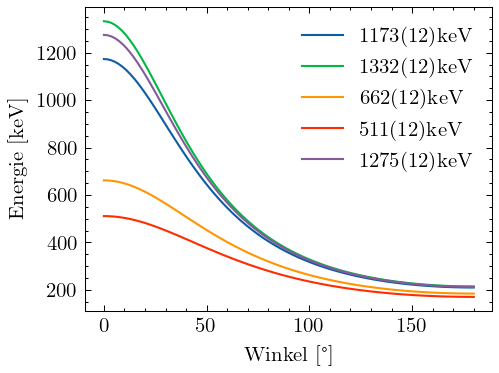

In [17]:
phi = radian(np.linspace(0,180,100))
for e in kalib_energies:
    plt.plot(degree(phi),kev(photon_energy(joule(e.n),phi)),label=f'{e:S}keV')
plt.legend()

plt.xlabel('Winkel [°]')
plt.ylabel('Energie [keV]')

## 2 Streuwinkel

### import data

In [18]:
streuwinkel = [0,10, 30, 50, 70, 90, 110,130]
streuwinkel = unp.uarray(streuwinkel,0.5)
streu_data = []*len(streuwinkel)
for i in streuwinkel:
    streu_data.append(pd.read_csv(f'Compton/data/2-Comptonspektrum/{int(i.n)}_grad.txt', sep='\t', header=None, names=['channel', 'counts']))
streu_data[len(streu_data)-1]

,channel,counts
0,0,21
1,1,89
2,2,33
3,3,21
4,4,38
...,...,...
251,251,4
252,252,1
253,253,1
254,254,2


### analyze data

Text(0, 0.5, 'Intensität')

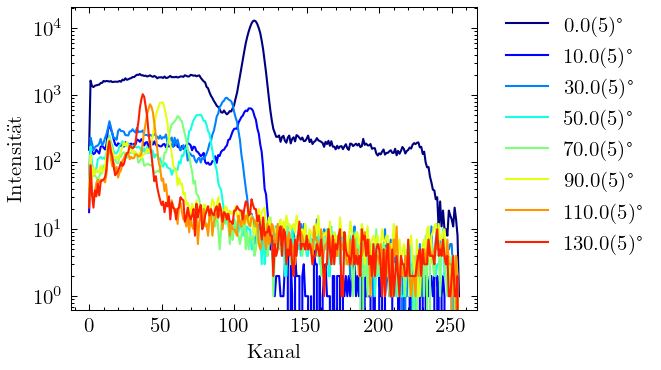

In [19]:
plt.figure()
for i in range(len(streu_data)):
    plt.plot(streu_data[i]['channel'], streu_data[i]['counts'], label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)


plt.xlabel('Kanal')
plt.ylabel('Intensität')

## 3 Rückstoßelektronen

### import data

In [20]:
rueckstoss_data = pd.read_csv('Compton/data/3-Elektronenstreuung/elektronspektr.txt', sep='\t', header=None, names=['channel', 'counts'])

### analyze data

Text(0, 0.5, 'Counts')

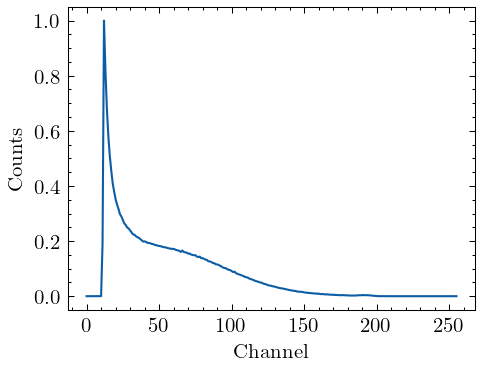

In [21]:
plt.figure()
plt.plot(rueckstoss_data['channel'], simple_norm(rueckstoss_data['counts']), label='Rückstosselektronen')

plt.xlabel('Channel')
plt.ylabel('Counts')

Count = -1.255(9)e+04 * erf(0.02050(23)*(channel-94.58(23))) + 1.297(5)e+04
Comptonkante = 94.58(23)


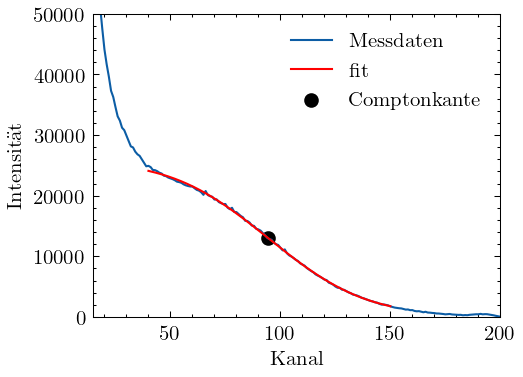

In [22]:
plt.figure()
xmin,xmax = 40,150
x,y = rueckstoss_data['channel'][xmin:xmax], rueckstoss_data['counts'][xmin:xmax]
plt.plot(rueckstoss_data['channel'], rueckstoss_data['counts'], label='Messdaten')

# fit with error function
def erf(x,a,b,c,d):
    return a*sp.erf(b*(x-c))+d

popt,pcov = curve_fit(erf,x,y,p0=[-10000,0.01,100,10000],sigma=np.sqrt(y))
perr = np.sqrt(np.diag(pcov))
xl = np.linspace(xmin,xmax,500)
plt.plot(xl,erf(xl,*popt),label='fit',c='r')
c = unp.uarray(popt,perr)
print(f'Count = {c[0]:S} * erf({c[1]:S}*(channel-{c[2]:S})) + {c[3]:S}')
compton_kante = c[2]
print(f"Comptonkante = {compton_kante:S}")

plt.scatter(compton_kante.n,erf(compton_kante.n,*popt),label='Comptonkante',c='k')


plt.xlim(15,200)
plt.ylim(0,50000)


def e_energy(channel):
    return kev(electron_energy(joule(kalib_energies[2]),np.deg2rad(180)))*channel/compton_kante

plt.legend()

plt.xlabel('Kanal')
plt.ylabel('Intensität')

plt.savefig('Compton/output/3-comptonkante.pdf', bbox_inches='tight')

Text(0, 0.5, 'Counts')

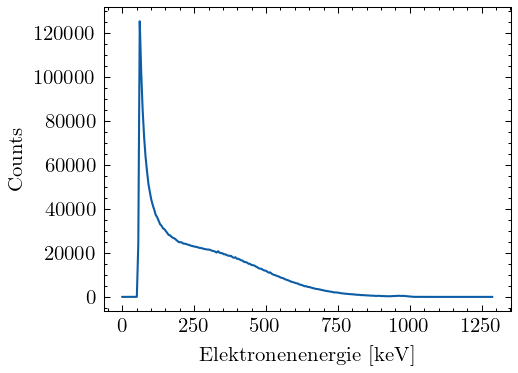

In [23]:
plt.figure()
plt.plot(unp.nominal_values(e_energy(rueckstoss_data['channel'])), rueckstoss_data['counts'], label='Rückstosselektronen')

plt.xlabel('Elektronenenergie [keV]')
plt.ylabel('Counts')

## 4 Koinzidenz

### import data

In [24]:
koinzidenz_winkel = [50,70,90,110,130]
koinzidenz_winkel = unp.uarray(koinzidenz_winkel,0.5)
koinzidenz_data = []*len(koinzidenz_winkel)
for i in koinzidenz_winkel:
    koinzidenz_data.append(pd.read_csv(f'Compton/data/4-Koinzidenz/{int(i.n)}_grad.txt', sep='\t', header=None, names=['channel', 'count']))
koinzidenz_data[0]

,channel,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
251,251,0
252,252,0
253,253,0
254,254,0


### analyze data

Text(0, 0.5, 'Count')

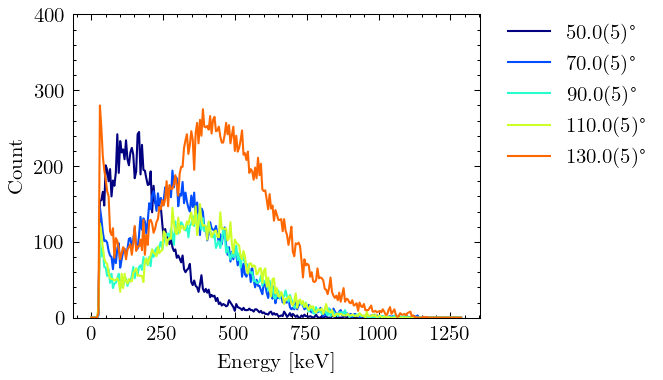

In [25]:
plt.figure()
for i in range(len(koinzidenz_data)):
    x,y= e_energy(koinzidenz_data[0]['channel']), koinzidenz_data[i]['count']
    plt.plot(unp.nominal_values(x),y, label=f'{koinzidenz_winkel[i]:S}°',color=mapcolors(len(koinzidenz_data))[i])
# plt.yscale('log')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.ylim(0,400)
# plt.xlim(0,200)
plt.xlabel('Energy [keV]')
plt.ylabel('Count')


## 5 Energien der Photopeaks

f_{0°)} &= \num{665.84 \pm 0.33} \cdot \exp(-\frac{(\num{665.84 \pm 0.33}-x)^2}{2\cdot (\num{28.09 \pm 0.35})^2})\\
f_{10°)} &= \num{639.0 \pm 1.1} \cdot \exp(-\frac{(\num{639.0 \pm 1.1}-x)^2}{2\cdot (\num{37.0 \pm 1.3})^2})\\
f_{30°)} &= \num{548.9 \pm 0.5} \cdot \exp(-\frac{(\num{548.9 \pm 0.5}-x)^2}{2\cdot (\num{35.1 \pm 0.6})^2})\\
f_{50°)} &= \num{433.2 \pm 0.5} \cdot \exp(-\frac{(\num{433.2 \pm 0.5}-x)^2}{2\cdot (\num{36.5 \pm 0.6})^2})\\
f_{70°)} &= \num{340.8 \pm 0.6} \cdot \exp(-\frac{(\num{340.8 \pm 0.6}-x)^2}{2\cdot (\num{31.5 \pm 0.7})^2})\\
f_{90°)} &= \num{272.2 \pm 0.6} \cdot \exp(-\frac{(\num{272.2 \pm 0.6}-x)^2}{2\cdot (\num{23.9 \pm 0.6})^2})\\
f_{110°)} &= \num{225.1 \pm 1.0} \cdot \exp(-\frac{(\num{225.1 \pm 1.0}-x)^2}{2\cdot (\num{19.3 \pm 1.0})^2})\\
f_{130°)} &= \num{195.4 \pm 1.0} \cdot \exp(-\frac{(\num{195.4 \pm 1.0}-x)^2}{2\cdot (\num{16.4 \pm 1.0})^2})\\


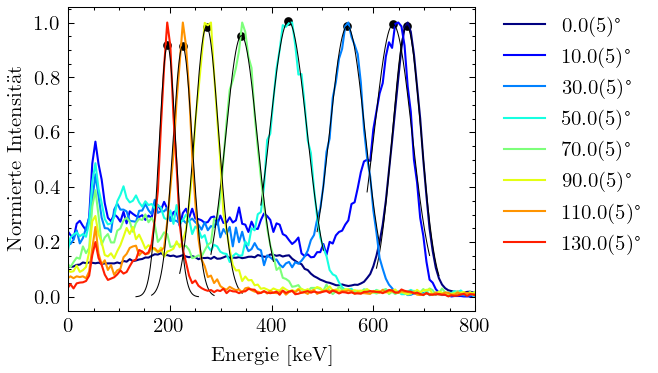

In [26]:
streu_energies = np.array([])
plt.figure()
for i in range(len(streu_data)):
    x,y = unp.nominal_values(energy(streu_data[i]['channel'])), simple_norm(streu_data[i]['counts'])
    plt.plot(x,y, label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])


    peak = np.where(y==np.max(y))[0][0]
    xl = np.linspace(x[peak-10],x[peak+10],500)
    c,pcov = curve_fit(gauss,x[peak-10:peak+10],y[peak-10:peak+10],p0=[x[peak],y[peak],x[peak+3]-x[peak-3]])
    print(rf"f_{{{int(streuwinkel[i].n)}°)}} &= \num{{{un.ufloat(c[0],np.sqrt(pcov[0][0])):L}}} \cdot \exp(-\frac{{(\num{{{un.ufloat(c[0],np.sqrt(pcov[0][0])):L}}}-x)^2}}{{2\cdot (\num{{{un.ufloat(c[2],np.sqrt(pcov[2][2])):L}}})^2}})\\")
    # print(f'{un.ufloat(c[0],np.sqrt(pcov[0,0])):S}keV')
    plt.plot(xl,gauss(xl,*c),c='k',lw=0.5)
    plt.scatter(c[0],gauss(c[0],*c),c='k',s=10)
    
    streu_energies = np.append(streu_energies,un.ufloat(c[0],np.sqrt(pcov[0,0])))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)
plt.xlim(0,800)
# plt.ylim(10,20000)
plt.ylabel('Normierte Intensität')
plt.xlabel('Energie [keV]')
plt.savefig('Compton/output/5-photon-fit.pdf', bbox_inches='tight')

Text(0, 0.5, 'Energie [keV]')

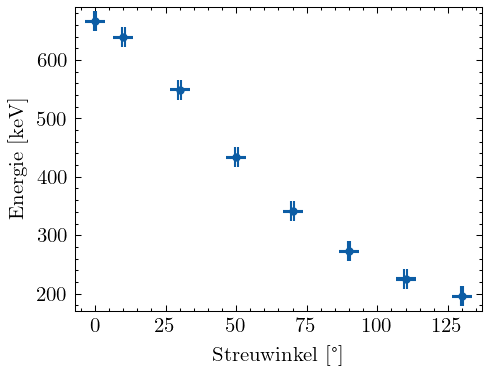

In [27]:
plt.figure()
plt.errorbar(unp.nominal_values(streuwinkel),unp.nominal_values(streu_energies),unp.std_devs(streu_energies),unp.std_devs(streuwinkel),fmt='.',label='data')
plt.xlabel('Streuwinkel [°]')
plt.ylabel('Energie [keV]')

f_{50°} &= \num{145 \pm 4} \cdot \exp(-\frac{(\num{145 \pm 4}-x)^2}{2\cdot (\num{106 \pm 5})^2})\\
f_{70°} &= \num{293.3 \pm 3.3} \cdot \exp(-\frac{(\num{293.3 \pm 3.3}-x)^2}{2\cdot (\num{156 \pm 6})^2})\\
f_{90°} &= \num{355.2 \pm 3.3} \cdot \exp(-\frac{(\num{355.2 \pm 3.3}-x)^2}{2\cdot (\num{167 \pm 5})^2})\\
f_{110°} &= \num{370 \pm 4} \cdot \exp(-\frac{(\num{370 \pm 4}-x)^2}{2\cdot (\num{169 \pm 7})^2})\\
f_{130°} &= \num{433.7 \pm 2.9} \cdot \exp(-\frac{(\num{433.7 \pm 2.9}-x)^2}{2\cdot (\num{181 \pm 5})^2})\\


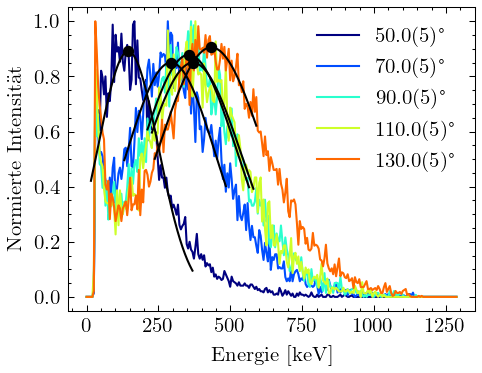

In [28]:
w = 19
electron_energies = np.array([])
electron_angles = np.array([])
plt.figure()
for i in range(len(koinzidenz_data)):
    x,y= unp.nominal_values(e_energy(koinzidenz_data[i]['channel'])), simple_norm(koinzidenz_data[i]['count'])
    plt.plot(unp.nominal_values(x),y, label=f'{koinzidenz_winkel[i]:S}°',color=mapcolors(len(koinzidenz_data))[i])

    peak = np.where(y==np.max(y[7:]))[0][0]
    xl = np.linspace(x[peak-30],x[peak+40],500)
    c,pcov = curve_fit(gauss,x[peak-30:peak+40],y[peak-30:peak+40],p0=[x[peak],y[peak],x[peak+3]-x[peak-3]])
    print(rf"f_{{{int(koinzidenz_winkel[i].n)}°}} &= \num{{{un.ufloat(c[0],np.sqrt(pcov[0][0])):L}}} \cdot \exp(-\frac{{(\num{{{un.ufloat(c[0],np.sqrt(pcov[0][0])):L}}}-x)^2}}{{2\cdot (\num{{{un.ufloat(c[2],np.sqrt(pcov[2][2])):L}}})^2}})\\")
    # print(f'{un.ufloat(c[0],np.sqrt(pcov[0,0])):S}keV')
    plt.plot(xl,gauss(xl,*c),c='k',zorder=10)
    plt.scatter(c[0],gauss(c[0],*c),c='k',s=20,zorder=10)
    electron_energies = np.append(electron_energies,un.ufloat(c[0],np.sqrt(pcov[0,0])))
    electron_angles = np.append(electron_angles,koinzidenz_winkel[i])

plt.legend()


plt.xlabel('Energie [keV]')
plt.ylabel('Normierte Intensität')

plt.savefig('Compton/output/5-electron-fit.pdf', bbox_inches='tight')

Text(0, 0.5, 'Energie [keV]')

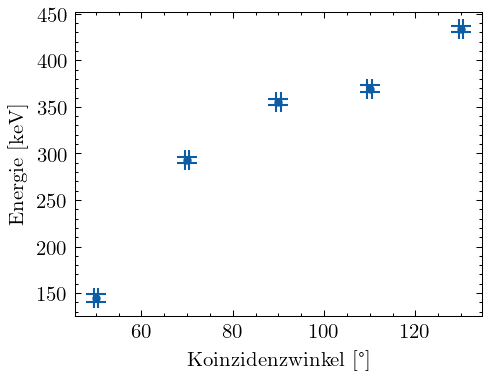

In [29]:
plt.figure()
plt.errorbar(unp.nominal_values(electron_angles),unp.nominal_values(electron_energies),unp.std_devs(electron_energies),unp.std_devs(electron_angles),fmt='.',label='data')
plt.xlabel('Koinzidenzwinkel [°]')
plt.ylabel('Energie [keV]')

50.0(5)°: 145(4) + 433.2(5)keV = 578(4)keV
70.0(5)°: 293.3(3.3) + 340.8(6)keV = 634.1(3.4)keV
90.0(5)°: 355.2(3.3) + 272.2(6)keV = 627.4(3.3)keV
110.0(5)°: 370(4) + 225.1(1.0)keV = 595(4)keV
130.0(5)°: 433.7(2.9) + 195.4(1.0)keV = 629.1(3.0)keV
Energy of the sum: 618(10)keV


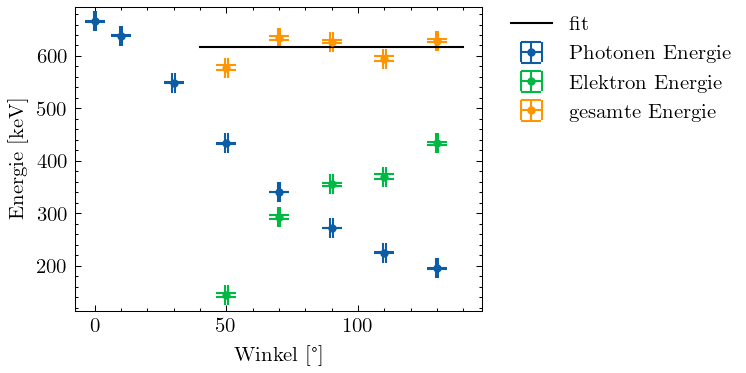

In [30]:
def const(x,a):
    return a*np.ones(len(x))

plt.figure()
plt.errorbar(unp.nominal_values(streuwinkel),unp.nominal_values(streu_energies),unp.std_devs(streu_energies),unp.std_devs(streuwinkel),fmt='.',label='Photonen Energie')
plt.errorbar(unp.nominal_values(electron_angles),unp.nominal_values(electron_energies),unp.std_devs(electron_energies),unp.std_devs(electron_angles),fmt='.',label='Elektron Energie')

# add values with same angl
sum_energies = np.array([])
for i in range(len(electron_angles)):
    for j in range(len(streuwinkel)):
        if (electron_angles[i].n == streuwinkel[j].n):
            print(f'{electron_angles[i]:S}°: {electron_energies[i]:S} + {streu_energies[j]:S}keV = {electron_energies[i]+streu_energies[j]:S}keV')
            sum_energies = np.append(sum_energies,electron_energies[i]+streu_energies[j])

plt.errorbar(unp.nominal_values(electron_angles),unp.nominal_values(sum_energies),unp.std_devs(sum_energies),unp.std_devs(electron_angles),fmt='.',label='gesamte Energie')

xl = np.linspace(40,140,100)
popt, pcov = curve_fit(const,unp.nominal_values(electron_angles),unp.nominal_values(sum_energies),sigma=unp.std_devs(sum_energies))
plt.plot(xl,const(xl,*popt),label='fit',c='k')
sum_energy = un.ufloat(popt[0],np.sqrt(pcov[0][0]))
print(f'Energy of the sum: {sum_energy:S}keV')

plt.xlabel('Winkel [°]')
plt.ylabel('Energie [keV]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('Compton/output/5-streu-energien.pdf', bbox_inches='tight')

## 6 Ruhemasse des Elektrons

1/E = \SI{2.212 \pm 0.032}{\per\mega\electronvolt} \cdot (1-\cos(\theta)) +  \SI{1.507 \pm 0.005}{\per\mega\electronvolt}
m_e = \left(8.06 \pm 0.12\right) \times 10^{-31} kg
lit. m_e = 9.1093837015e-31kg


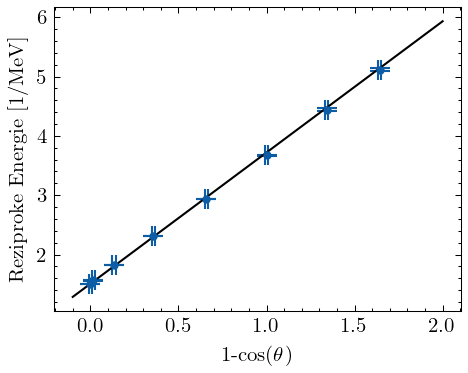

In [31]:
rez_energies = 1/streu_energies*1e3
x = unp.uarray(1-np.cos(np.deg2rad(unp.nominal_values(streuwinkel))),np.deg2rad(unp.std_devs(streuwinkel)))
plt.figure()
plt.errorbar(unp.nominal_values(x),unp.nominal_values(rez_energies),unp.std_devs(rez_energies),unp.std_devs(x),fmt='.',label='data')

xl = np.linspace(-0.1,2,100)
c, cov = curve_fit(linfit,unp.nominal_values(x),unp.nominal_values(rez_energies),sigma=unp.std_devs(rez_energies))
plt.plot(xl,linfit(xl,*c),label='fit',color='k')
a = un.ufloat(c[0],np.sqrt(cov[0][0]))
b = un.ufloat(c[1],np.sqrt(cov[1][1]))

print(rf'1/E = \SI{{{a:L}}}{{\per\mega\electronvolt}} \cdot (1-\cos(\theta)) +  \SI{{{b:L}}}{{\per\mega\electronvolt}}')
m_e = 1/(con.c**2*a*1e-6/con.e)
print(f'm_e = {m_e:L} kg')
print(f'lit. m_e = {con.m_e}kg')

plt.xlabel(r'1-cos($\theta$)')
plt.ylabel('Reziproke Energie [1/MeV]')

plt.savefig('Compton/output/6-elektronenmasse.pdf', bbox_inches='tight')

In [32]:
def radius(m_e):
    return con.e**2/(m_e*con.c**2*4*con.pi*con.epsilon_0)

print(m_e)
print(con.m_e)

print(f'Radius of the electron: {radius(m_e):S}m')
print(f'lit. Radius: {radius(con.m_e)}m')

(8.06+/-0.12)e-31
9.1093837015e-31
Radius of the electron: 3.19(5)e-15m
lit. Radius: 2.817940326204929e-15m


## 7 streuquerschnitt

In [33]:
def read_livetime(grad):
    with open(f"Compton/data/2-Comptonspektrum/{int(grad)}_grad.mcd") as f:
        for i, line in enumerate(f):
            if i == 5:
                return float(line.split()[1])

livetimes = []*len(streuwinkel)
for w in streuwinkel:
    livetimes.append(read_livetime(w.n))

livetimes = unp.uarray(livetimes,0.05)

Winkel 	 Peak cps
0.0 	 9.37(15)e+03
10.0 	 99(4)
30.0 	 29.6(6)
50.0 	 19.2(4)
70.0 	 14.7(4)
90.0 	 11.5(4)
110.0 	 12.3(9)
130.0 	 15.4(1.3)


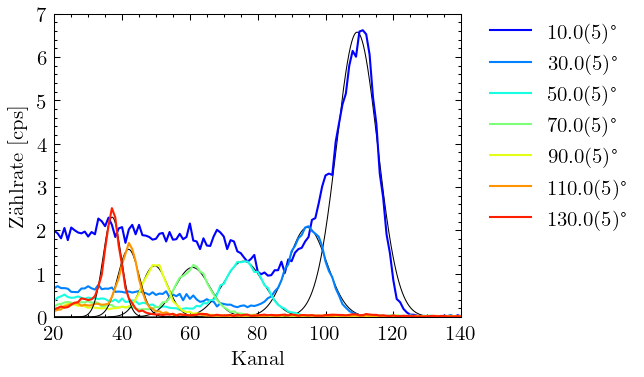

In [47]:
streu_querschnitt = []*len(streuwinkel)
streu_qs_area = []*len(streuwinkel)
plt.figure()
print('Winkel \t Peak cps')
# print('Winkel \t Peak cps \t u(Peak) \t Fläche \t u(Fläche)')
for i in range(len(streu_data)):
    x,y = streu_data[i]['channel'],  unp.nominal_values(streu_data[i]['counts']/livetimes[i])
    peak = np.where(y==np.max(y))[0][0]
    xl = np.linspace(x[peak-25],x[peak+25],500)
    c,pcov = curve_fit(gauss,x[peak-10:peak+10],y[peak-10:peak+10],p0=[x[peak],y[peak],x[peak+3]-x[peak-3]])
    perr = np.sqrt(np.diag(pcov))
    # print(f'{un.ufloat(c[0],np.sqrt(pcov[0,0])):S}keV')
    print(f'{streuwinkel[i].n} \t {gauss_area(uf(c[1],perr[1]),uf(c[2],perr[2])):S}')
    # print(f'{streuwinkel[i].n} \t {un_gauss(uf(c[0],perr[0]),uf(c[0],perr[0]),uf(c[1],perr[1]),uf(c[2],perr[2])).n} \t {un_gauss(uf(c[0],perr[0]),uf(c[0],perr[0]),uf(c[1],perr[1]),uf(c[2],perr[2])).s} \t {gauss_area(uf(c[1],perr[1]),uf(c[2],perr[2])).n} \t {gauss_area(uf(c[1],perr[1]),uf(c[2],perr[2])).s}')

    

    # plt.plot(x[peak-5:pestreuquerschnittak+7],y[peak-5:peak+7], label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])
    if i == 0:
        pass
    else:
        plt.plot(xl,gauss(xl,*c),c='k',lw=0.5)
        # plt.scatter(c[0],gauss(c[0],*c),c='k',s=10)
        plt.plot(x,y, label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])

    streu_querschnitt = np.append(streu_querschnitt, np.sum(y[peak-5:peak+7]))
    streu_qs_area = np.append(streu_qs_area, gauss_area(uf(c[1],perr[1]),uf(c[2],perr[2])))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)
plt.ylim(0,7)
plt.xlim(20,140)
# plt.yscale('log')
# plt.ylim(10,20000)
plt.ylabel('Zählrate [cps]')
plt.xlabel('Kanal')

plt.savefig('Compton/output/7-Zaehlrate.pdf', bbox_inches='tight')


Text(0, 0.5, 'fläche [cps]')

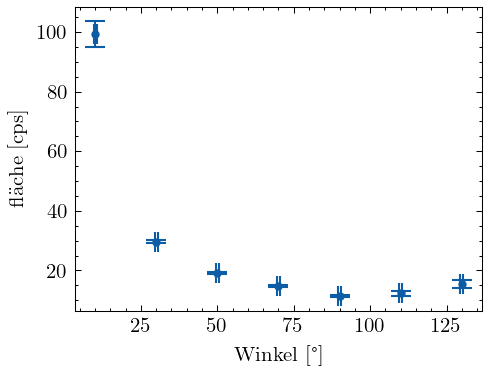

In [35]:
plt.errorbar(nv(streuwinkel[1:]),nv(streu_qs_area[1:]),sd(streu_qs_area[1:]),sd(streuwinkel[1:]),fmt='.',label='data')
plt.xlabel('Winkel [°]')
plt.ylabel('fläche [cps]')

In [36]:
def thompson(angle):
    return radius(con.m_e)**2*(1+np.cos(angle)**2)/2

def klein_nishina(angle):
    # return radius(con.m_e)**2*(1+np.cos(angle)**2)**2/(2*(1+np.cos(angle)))
    return radius(con.m_e)**2*epsilon(angle)**2*(epsilon(angle) +1/epsilon(angle)- np.sin(angle)**2)/2

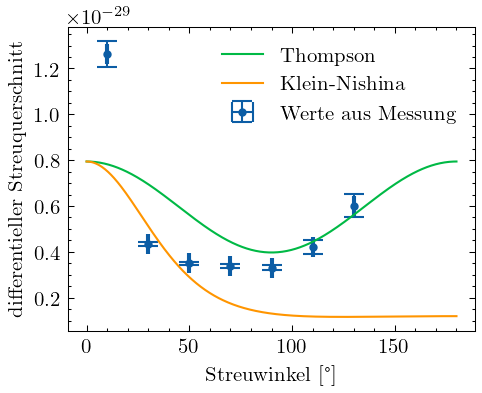

In [45]:
# plt.scatter(unp.nominal_values(streuwinkel[1:]),unp.nominal_values(streu_querschnitt[1:]),label='data')
# plt.errorbar(unp.nominal_values(streuwinkel[1:]),unp.nominal_values(streu_querschnitt[1:]),unp.std_devs(streu_querschnitt[1:]),unp.std_devs(streuwinkel[1:]),fmt='.',label='data area')
# plt.errorbar(unp.nominal_values(streuwinkel[1:]),unp.nominal_values(streu_qs_area[1:]),unp.std_devs(streu_qs_area[1:]),unp.std_devs(streuwinkel[1:]),fmt='.',label='fit area')
# plt.scatter(nv(streuwinkel[1:]),1.248e-31*nv(streu_qs_area[1:])/epsilon(np.deg2rad(nv(streuwinkel[1:]))),label='data')
plt.errorbar(nv(streuwinkel[1:]),1.248e-31*nv(streu_qs_area[1:])/(epsilon(np.deg2rad(nv(streuwinkel[1:])))),1.248e-31*sd(streu_qs_area[1:])/(epsilon(np.deg2rad(nv(streuwinkel[1:])))),sd(streuwinkel[1:]),fmt='.',label='Werte aus Messung')
xl = np.linspace(0,180,500)
plt.plot(xl,thompson(np.deg2rad(xl)),label='Thompson')
# klein-nishina
plt.plot(xl,klein_nishina(np.deg2rad(xl)),label='Klein-Nishina')

plt.legend()

plt.xlabel('Streuwinkel [°]')
plt.ylabel('differentieller Streuquerschnitt')

plt.savefig('Compton/output/7-streuquerschnitt.pdf', bbox_inches='tight')

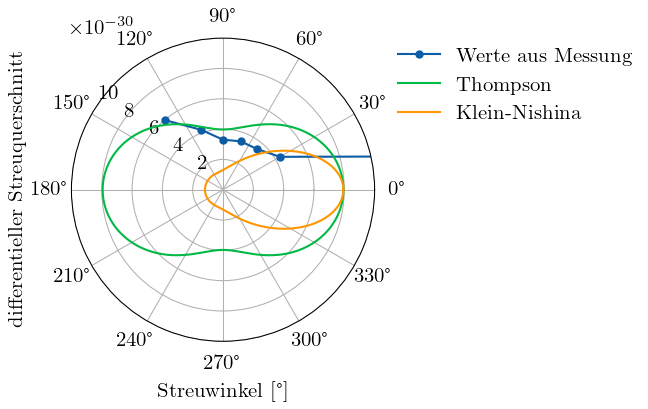

In [46]:
plt.figure()

xl = np.linspace(0,360,500)
xl = np.deg2rad(xl)

ax = plt.subplot(111, projection='polar')
plt.polar(np.deg2rad(nv(streuwinkel[1:])),1.248e-31*nv(streu_qs_area[1:])/epsilon(np.deg2rad(nv(streuwinkel[1:]))),label='Werte aus Messung',marker='.')

plt.polar(xl,thompson(xl),label='Thompson')
plt.polar(xl,klein_nishina(xl),label='Klein-Nishina')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)

ax.set_rmax(1e-29)



ax.set_xlabel('Streuwinkel [°]')
ax.set_ylabel('differentieller Streuquerschnitt')

# ax.xaxis.set_label_coords(1.4,0.5)
ax.yaxis.set_label_coords(-0.15,0.5)
ax.set_rlabel_position(145)
ax.set_thetagrids(np.arange(0, 360, 30))

plt.savefig('Compton/output/7-streuquerschnitt-polar.pdf', bbox_inches='tight')